In [319]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, hamming_loss, accuracy_score
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = "second" # "second"
path = "./second_dataset/mbti_1.csv"
if dataset == "third":
    path = "./third_dataset/MBTI 500.csv"
seed = 0
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True
# Data
train_fraction = 0.80
val_fraction = 0.10
vocab_size = 20000
seq_len = 256 
vocab = "vocab"
preset_token = ["__pad__", "__url__", "__sep__", "__tar__", "__unk__"]
token_col = "tokens"
target_cols = ["I_E", "N_S", "T_F", "J_P"]
pad_id = 0

# Model
cfg_embed_dim = 256 # (128, 256, 384, 512) 
cfg_hidden_dim = 128 # (128, 256, 384, 512)
cfg_num_layers = 2 # (1, 2, 3)
cfg_dropout = 0.5 # 0.2-0.5
cfg_bidirectional = False

# Train
cfg_batch_size = 64 # (64, 128, 256)
cfg_lr = 1e-4        # (5e-5, 1e-4, 5e-4, 1e-3) 
cfg_weight_decay = 1e-2 # (5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2)
cfg_epochs = 30
cfg_max_grad_norm = 0.5 # (0.5–2.0)
cfg_weight_cap = 50 # [20, 50, 100]


cfg_thresholds = [0.5]*4 #[0.44, 0.31, 0.6, 0.96], best thresholds rely on model


In [320]:
# Data curation
import regex
def preprocess_df(df):
    posts = df["posts"]
    types = df["type"]
    
    posts = posts.replace(r"http[^\s|]+", " __url__ ", regex=True)
    posts = posts.str.replace("|||", " __sep__ ", regex=False)
    posts = posts.replace(r"(?i)\b[IE][NS][TF][JP]\b", " __tar__ ", regex=True) # i.e. INTP, ENFJ
    posts = posts.replace(r"\s+", " ", regex=True) # remove excess spaces
    rx = regex.compile(r"[^_\p{White_Space}\p{scx=Latin}5\p{Nd}\p{Emoji}]+") # remove everything that is not _, " ", latin, or emojis
    posts = posts.apply(lambda s: rx.sub("", s))
    
    types = types.replace(r"I|N|T|J", "1", regex=True)
    types = types.replace(r"E|S|F|P", "0", regex=True)
    
    df["posts"] = posts
    df["type"] = types
    
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

    df[["I_E", "N_S", "T_F", "J_P"]] = (
        df["type"].apply(lambda s: pd.Series([int(c) for c in s]))
    ).astype("int32")

    return df

In [321]:
import pandas as pd

def equal_dist_sample(df, total_n=10_000, seed=seed) -> pd.DataFrame:
    counts = df["type"].value_counts()
    amt_classes = len(counts)
    amt_per_class = total_n // amt_classes
    need = pd.Series(amt_per_class, index=counts.index)
    out = need.clip(upper=counts)
    


    parts = [
        df[df["type"] == cls].sample(n=int(out[cls]), random_state=seed)
        for cls in out.index
        if int(out[cls]) > 0
    ]
    out = pd.concat(parts, ignore_index=True).sample(frac=1, random_state=seed).reset_index(drop=True)
    return out
df = pd.read_csv(path)
counts = df["type"].value_counts()
print(counts)
print(sum(counts.values))


type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64
8675


In [322]:
# train/test split
torch.manual_seed = seed
df = pd.read_csv(path)
df = preprocess_df(df)
if dataset == "third":
    df = equal_dist_sample(df)
print(df)
n = len(df)
n_train = int(train_fraction * n)
n_val = int((val_fraction + train_fraction) * n)

train_df = df[ : n_train]
val_df = df[n_train : n_val]
test_df = df[n_val : ]

      type                                              posts  I_E  N_S  T_F  \
0     1000  Dear __tar__ Mother I wish you were less of a ...    1    0    0   
1     1101  To me I think you guys may be over analyzing i...    1    1    0   
2     0100  NIHM While NIHM has her __tar__ husband Ive go...    0    1    0   
3     1110  I want 5 kids  an astronucleartheoretical phys...    1    1    1   
4     1000  I have the same thing as well Ive noticed that...    1    0    0   
...    ...                                                ...  ...  ...  ...   
8670  1100  Hey It seems like you have a great foundation ...    1    1    0   
8671  1101  Dear __tar__ mother When I started my very fir...    1    1    0   
8672  1110  Oh ENTJs how can you be scary and exciting at ...    1    1    1   
8673  0101  Hi __tar__  and welcome to the forumwink __sep...    0    1    0   
8674  0110  Interesting youve gone from Se dominant to Ne ...    0    1    1   

      J_P  
0       0  
1       1  
2  

In [323]:
# Tokenizing

from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.normalizers import BertNormalizer
from tokenizers.pre_tokenizers import BertPreTokenizer
from pathlib import Path


def tokenize():
    tok = Tokenizer(WordPiece(unk_token="__unk__"))
    tok.normalizer = BertNormalizer(lowercase=True)
    tok.pre_tokenizer = BertPreTokenizer()

    trainer = WordPieceTrainer(vocab_size=vocab_size, special_tokens=preset_token)
    tok.train_from_iterator(train_df["posts"], trainer=trainer)

    tok.save(str(Path(path).parent / "tokenizer.json"))
    print("saved at:", str(Path(path).parent / "tokenizer.json"))
    return tok




In [324]:
# load tokenizer
if dataset == "third":
    tok = tokenize()
else:
    try:
        tok = Tokenizer.from_file(str(Path(path).parent / "tokenizer.json"))
    except:
        print("creating new Tokenizer")
        tok = tokenize()

pad_id = tok.token_to_id("__pad__")
tok.enable_padding(length=seq_len, pad_id=pad_id, pad_token="__pad__")
tok.enable_truncation(max_length=seq_len)

def add_input_ids(df, tok, text_col="posts", out_col=token_col):
    encs = tok.encode_batch(df[text_col].astype(str).tolist())
    df = df.copy()
    df[out_col] = [e.ids for e in encs]
    return df

train_df = add_input_ids(train_df, tok, text_col="posts", out_col=token_col)
val_df   = add_input_ids(val_df,   tok, text_col="posts", out_col=token_col)
test_df  = add_input_ids(test_df,  tok, text_col="posts", out_col=token_col)

y_train = train_df[target_cols].to_numpy(dtype=np.int32)
y_val = val_df[target_cols].to_numpy(dtype=np.int32)
y_test  = test_df[target_cols].to_numpy(dtype=np.int32)


In [325]:
# Majority Guessing baseline 

def eval(y_true, y_pred):
    exact_match = np.mean(np.all(y_true == y_pred, axis=1))
    per_label_acc = (y_true == y_pred).mean(axis=0)
    micro_f1 = f1_score(y_true, y_pred, average="micro", zero_division=0)
    macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    h_loss = hamming_loss(y_true, y_pred)

    print("Exact match:", exact_match)
    print("Hamming loss:", h_loss)
    print("Micro F1:", micro_f1)
    print("Macro F1:", macro_f1)
    print("Per-label acc [I_E, N_S, T_F, J_P]:", per_label_acc)



priors = y_train.mean(axis=0)
majority_bits = (priors >= 0.5).astype(np.int32)
y_pred_majority = np.tile(majority_bits, (len(y_test), 1))
eval(y_test, y_pred_majority)

Exact match: 0.20622119815668202
Hamming loss: 0.31336405529953915
Micro F1: 0.7204522096608428
Macro F1: 0.4465365558676654
Per-label acc [I_E, N_S, T_F, J_P]: [0.76958525 0.84562212 0.52073733 0.61059908]


In [326]:
import torch.nn.functional as F

def balanced_bce_with_logits(logits, targets, pos_rate, weight_cap=cfg_weight_cap, reduction="mean"):
    targets = targets.float()
    epsilon = 1e-6

    w_pos = (0.5 / pos_rate + epsilon).clamp(max=weight_cap)
    w_neg = (0.5 / (1.0 - pos_rate + epsilon)).clamp(max=weight_cap)

    w = targets * w_pos + (1.0 - targets) * w_neg
    return F.binary_cross_entropy_with_logits(logits, targets, weight=w, reduction=reduction)

In [327]:
class LSTM_MBTI(nn.Module):
    def __init__(self, embed_dim=cfg_embed_dim, hidden_dim=cfg_hidden_dim, num_layers=cfg_num_layers, dropout=cfg_dropout if cfg_num_layers > 1 else 0.0, bidirectional=cfg_bidirectional):
        super().__init__()
        self.bidirectional = bidirectional

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=pad_id
        )

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=bidirectional
        )
        out_dim = hidden_dim * (2 if bidirectional else 1)
        
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(out_dim, 4)
        )

    def forward(self, input_ids):
        x = self.embedding(input_ids)
        out, _ = self.lstm(x)

        mask = (input_ids != pad_id).to(out.dtype)
        denom = mask.sum(dim=1, keepdim=True).clamp(min=1.0)
        pooled = (out * mask.unsqueeze(-1)).sum(dim=1) / denom

        return self.head(pooled)


In [328]:
from torch.utils.data import TensorDataset
def make_ds(df):
    x = torch.tensor(np.stack(df[token_col].to_list()), dtype=torch.long)
    y = torch.tensor(df[target_cols].to_numpy(np.float32), dtype=torch.float32)
    return TensorDataset(x, y)

In [329]:

train_ds = make_ds(train_df)
val_ds   = make_ds(val_df)
test_ds   = make_ds(test_df)

cfg_train_loader = DataLoader(train_ds, batch_size=cfg_batch_size, shuffle=True, num_workers=0,
                        pin_memory=torch.cuda.is_available())
cfg_val_loader = DataLoader(val_ds, batch_size=cfg_batch_size, shuffle=False,
                        pin_memory=torch.cuda.is_available())
cfg_test_loader = DataLoader(test_ds, batch_size=cfg_batch_size, shuffle=False,
                        pin_memory=torch.cuda.is_available())

In [330]:
import torch
import torch.nn as nn
import time
import copy
from tqdm.auto import tqdm
from IPython.display import display, update_display
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

@torch.no_grad()
def evaluate(model, loader, thresholds, weight_cap=cfg_weight_cap):
    model.eval()
    losses = []
    y_true_all = []
    y_pred_all = []
    probs_all = []

    pos_rate = torch.tensor(y_val.mean(axis=0), dtype=torch.float32, device=device)
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)

        
        loss = balanced_bce_with_logits(logits, y, pos_rate, weight_cap=weight_cap)
        losses.append(loss.item())

        probs = torch.sigmoid(logits).detach().cpu().numpy()
        y_true = y.detach().cpu().numpy().astype(np.int32)
        
        y_pred = (probs >= np.asarray(thresholds)[None, :]).astype(np.int32)

        y_true_all.append(y_true)
        y_pred_all.append(y_pred)
        probs_all.append(probs)

    
    
    y_true_all = np.vstack(y_true_all)
    y_pred_all = np.vstack(y_pred_all)
    probs_all = np.vstack(probs_all)
    
    per_label_f1 = []
    ap_label = []
    for j in range(4):
        f1_j = f1_score(y_true_all[:, j], y_pred_all[:, j], average="macro", zero_division=0)
        per_label_f1.append(f1_j)
        ap1 = average_precision_score(y_true_all[:, j], probs_all[:, j])
        ap0 = average_precision_score(1 - y_true_all[:, j], 1 - probs_all[:, j])
        ap_sym = 0.5 * (ap0 + ap1)
        ap_label.append(ap_sym)
    macro_ap = np.mean(ap_label)

    # sklearn:
    exact = accuracy_score(y_true_all, y_pred_all)
    micro = f1_score(y_true_all, y_pred_all, average="micro", zero_division=0)
    macro = f1_score(y_true_all, y_pred_all, average="macro", zero_division=0)
    ham = hamming_loss(y_true_all, y_pred_all)
    per_label_acc = (y_true_all == y_pred_all).mean(axis=0).tolist()
    
    
    return {
        "loss": float(np.mean(losses)),
        "hamming_loss": float(ham),
        "exact": float(exact),
        "microF1": float(micro),
        "macroF1": float(macro),
        "macroAP": float(macro_ap),
        "per_label_acc": per_label_acc,
        "per_label_f1": per_label_f1,
    }

def train(model, epochs=cfg_epochs, lr=cfg_lr, weight_decay=cfg_weight_decay, thresholds=cfg_thresholds, max_grad_norm=cfg_max_grad_norm,
        train_loader=cfg_train_loader, val_loader=cfg_val_loader, output=True, early_stop=False, weight_cap=cfg_weight_cap):
    model.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="max",
        factor=0.5,
        patience=2,
        threshold=5e-3,
        threshold_mode="rel"
    )
    
    pos_rate = torch.tensor(y_train.mean(axis=0), dtype=torch.float32, device=device)
    history = {
        "train_loss": [],
        "val_loss": [],
        "val_macroF1": [],
        "val_macroAP": [],
    }
    bad_epochs = 0
    best_ap = -np.inf
    best_f1 = -np.inf
    best_state = None
    state_epoch = 0
    val_display_id = "val_details"
    display("", display_id=val_display_id)
    pbar = tqdm(total=epochs)
    
    for epoch in range(1, epochs + 1):
        start = time.perf_counter()
        model.train()
        running = 0.0
        n_batches = 0

        for x, y in train_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            logits = model(x)
            

            loss = balanced_bce_with_logits(logits, y, pos_rate, weight_cap=weight_cap)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()
            running += loss.item()
            n_batches += 1

        epoch_time = time.perf_counter() - start
        val = evaluate(model, val_loader, thresholds=thresholds, weight_cap=weight_cap)
        
        scheduler.step(val["macroAP"])
        
        train_loss_epoch = running / max(n_batches, 1)
        history["train_loss"].append(float(train_loss_epoch))
        history["val_loss"].append(float(val["loss"]))
        history["val_macroF1"].append(float(val["macroF1"]))
        history["val_macroAP"].append(float(val["macroAP"]))
        pbar.set_description(f"Epoch {epoch}/{epochs}")
        if output:
            val_text = (f"VAL  loss={val['loss']:.3f} exact={val['exact']:.3f} hamming_loss={val['hamming_loss']:.3f} "
            f"microF1={val['microF1']:.3f} macroF1={val['macroF1']:.3f} "
            f"per_label_acc={np.round(val['per_label_acc'], 3)} per_label_f1={np.round(val['per_label_f1'], 3)}")
            update_display(val_text, display_id=val_display_id)
        else:
            print(f"macroF1={val["macroF1"]:.3f}")
            print(f"epoch_time={epoch_time:.2f}s")

        
        
        
        # Stop early if no improvement on AP
        bad_epochs_msg = ""
        epsilon = 1e-3
        if early_stop:
            patience = 10
            if val["macroAP"] > best_ap - epsilon:
                bad_epochs = 0
            else:
                bad_epochs += 1
                bad_epochs_msg = f"current bad epochs={bad_epochs}/{patience}"
                if bad_epochs > patience:
                    print(f"Early stopping. Best Macro AP={best_ap:.4f}")
                    break
        ap_delta = 1e-3
        f1_delta = 0.02
        
        if val["macroAP"]> best_ap:
            best_ap = val["macroAP"]
        if val["macroAP"] >= best_ap - ap_delta and val['macroF1'] > best_f1 - f1_delta:
            best_f1 = val['macroF1']
            best_state = copy.deepcopy(model.state_dict())
            state_epoch = epoch
            
        pbar.set_postfix_str(f"macroF1={val['macroF1']:.3f} epoch_time={epoch_time:.2f}s {bad_epochs_msg}")
        pbar.update(1)
        
    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"loaded model from epoch {state_epoch}")
        
    
    epochs_r = range(1, len(history["train_loss"]) + 1)

    plt.figure()
    plt.plot(epochs_r, history["train_loss"], label="train_loss")
    plt.plot(epochs_r, history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs_r, history["val_macroF1"], label="val_macroF1")
    plt.plot(epochs_r, history["val_macroAP"], label="val_macroAP")
    plt.xlabel("Epoch")
    plt.ylabel("Macro F1")
    plt.legend()
    plt.show()
    return model, best_f1


Tuning

In [100]:
# tune thresholds
def tune_thresholds(model, val_loader):
    iterate_thresholds = np.arange(0, 1, 0.01)
    max_vals  = [-np.inf] * 4
    best_thresholds = [-np.inf] * 4
    for threshold in iterate_thresholds:
        val = evaluate(model, val_loader, thresholds=[threshold]*4)
        for i in range(4):
            if val["per_label_f1"][i] > max_vals[i]:
                max_vals[i] = val["per_label_f1"][i]
                best_thresholds[i] = threshold
    print(best_thresholds)
    return best_thresholds



weight cap=20


'VAL  loss=0.691 exact=0.106 hamming_loss=0.423 microF1=0.626 macroF1=0.603 per_label_acc=[0.588 0.548 0.669 0.502] per_label_f1=[0.513 0.463 0.667 0.483]'

  0%|          | 0/30 [00:00<?, ?it/s]

loaded model from epoch 3


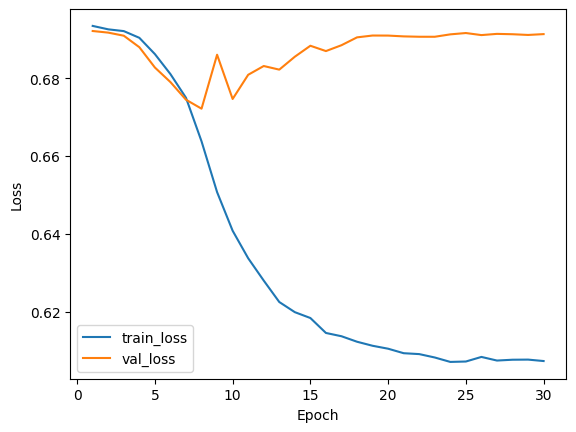

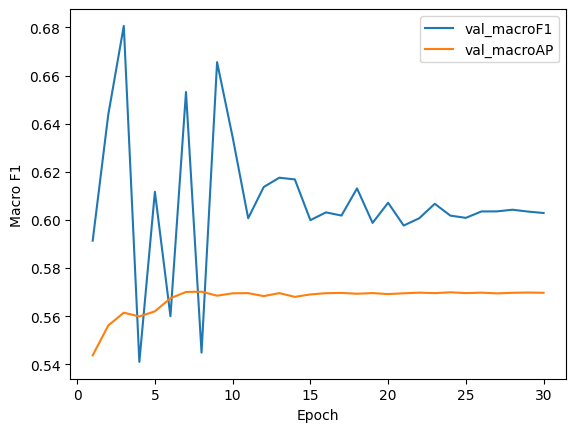

[np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5)]
current_best_score=0.6806007326883976 max_val=0.681 current best weight_cap=20
weight cap=50


'VAL  loss=0.691 exact=0.095 hamming_loss=0.429 microF1=0.620 macroF1=0.601 per_label_acc=[0.576 0.54  0.651 0.518] per_label_f1=[0.512 0.455 0.648 0.506]'

  0%|          | 0/30 [00:00<?, ?it/s]

loaded model from epoch 14


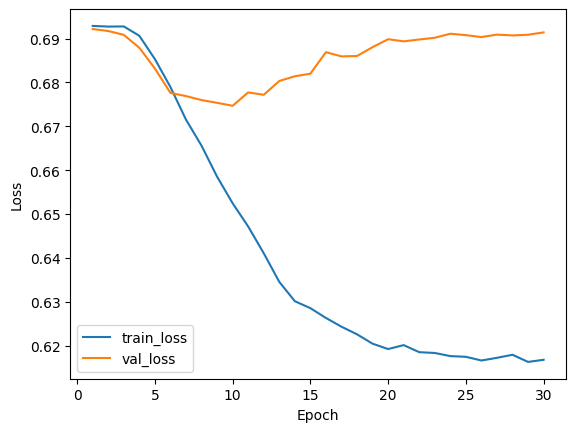

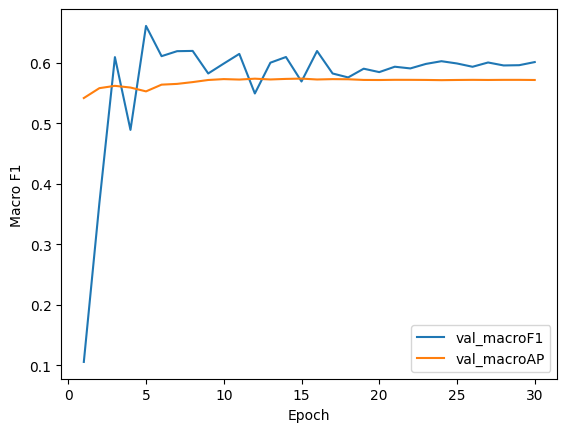

[np.float64(0.46), np.float64(0.4), np.float64(0.5700000000000001), np.float64(0.51)]
current_best_score=0.609617453124648 max_val=0.683 current best weight_cap=50
weight cap=100


'VAL  loss=0.690 exact=0.145 hamming_loss=0.400 microF1=0.656 macroF1=0.634 per_label_acc=[0.602 0.621 0.672 0.505] per_label_f1=[0.54  0.507 0.671 0.498]'

  0%|          | 0/30 [00:00<?, ?it/s]

loaded model from epoch 1


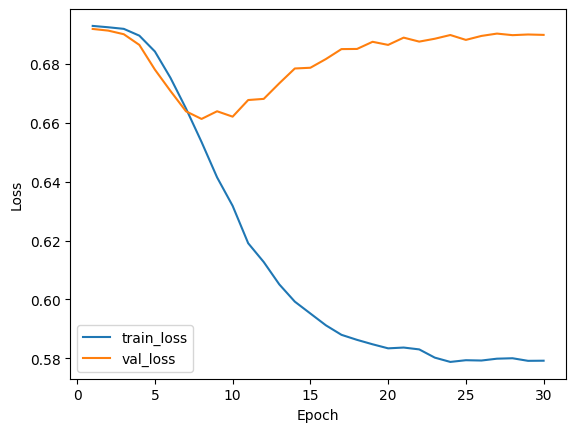

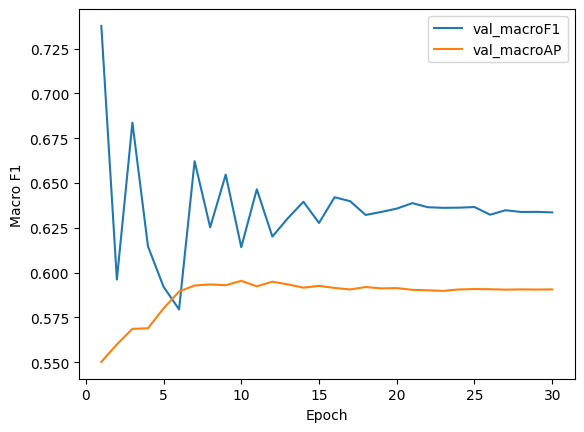

[np.float64(0.0), np.float64(0.5), np.float64(0.5), np.float64(0.51)]
current_best_score=0.7377113029227674 max_val=0.683 current best weight_cap=50


In [318]:
# tune weight_cap
iterate_weight_cap = [20, 50, 100]
max_val  = -np.inf
best_weight_cap = -np.inf
for weight_cap in iterate_weight_cap:
        model = LSTM_MBTI()
        print(f"weight cap={weight_cap}")
        model, best_score = train(model, weight_cap=weight_cap, output=True)
        thresholds = tune_thresholds(model, cfg_val_loader)
        val = evaluate(model, cfg_val_loader, thresholds=thresholds)
        if val["macroF1"] > max_val:
                max_val = val["macroF1"]
                best_weight_cap = weight_cap
        print(f"current_best_score={best_score}",f"max_val={max_val:.3f}",f"current best weight_cap={best_weight_cap}")

batch_size=64, with learning rate=0.0001


'VAL  loss=0.688 exact=0.156 hamming_loss=0.391 microF1=0.658 macroF1=0.629 per_label_acc=[0.612 0.621 0.671 0.531] per_label_f1=[0.54  0.518 0.669 0.509]'

  0%|          | 0/30 [00:00<?, ?it/s]

loaded model from epoch 7


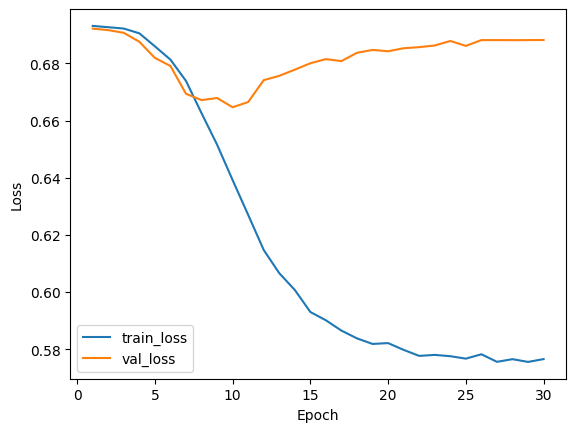

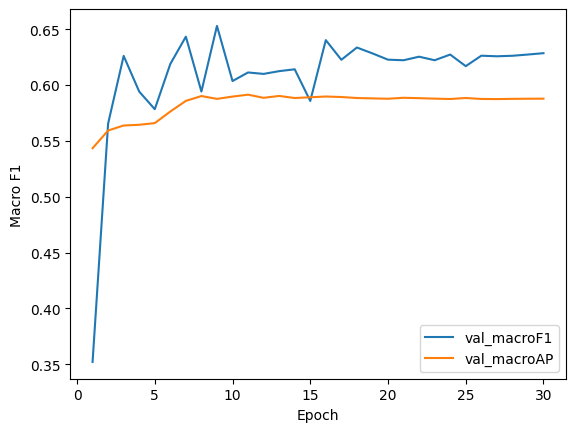

[np.float64(0.48), np.float64(0.47000000000000003), np.float64(0.5700000000000001), np.float64(0.52)]
current_best_score=0.6432894039917805 max_val=0.673 current best lr=0.0001 current best batch size=64
batch_size=64, with learning rate=0.0005


'VAL  loss=1.319 exact=0.212 hamming_loss=0.329 microF1=0.737 macroF1=0.690 per_label_acc=[0.689 0.795 0.654 0.546] per_label_f1=[0.567 0.544 0.649 0.537]'

  0%|          | 0/30 [00:00<?, ?it/s]

loaded model from epoch 3


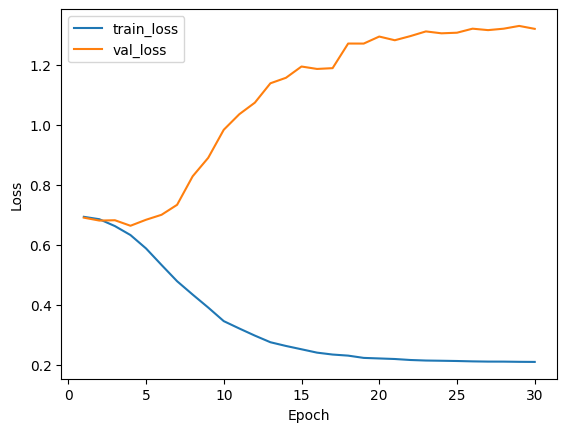

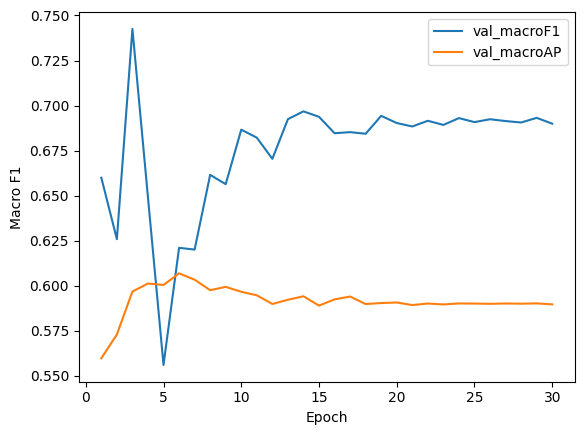

[np.float64(0.53), np.float64(0.52), np.float64(0.68), np.float64(0.56)]
current_best_score=0.7425275552762712 max_val=0.696 current best lr=0.0005 current best batch size=64
batch_size=64, with learning rate=0.001


'VAL  loss=0.683 exact=0.040 hamming_loss=0.502 microF1=0.487 macroF1=0.469 per_label_acc=[0.311 0.522 0.627 0.532] per_label_f1=[0.308 0.455 0.61  0.519]'

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
# tune batch_size and learning rate
iterate_batch_size = [64, 128, 256]
iterate_lr = [1e-4, 5e-4, 1e-3]
max_val  = -np.inf
best_batch_size = -np.inf
best_lr = -np.inf
for batch_size in iterate_batch_size:
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                        pin_memory=torch.cuda.is_available())
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                        pin_memory=torch.cuda.is_available())
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                        pin_memory=torch.cuda.is_available())
    
    for lr in iterate_lr:
        model = LSTM_MBTI()
        print(f"batch_size={batch_size}, with learning rate={lr}")
        model, best_score = train(model,
            train_loader=train_loader,
            val_loader=val_loader,
            lr=lr
        )
        thresholds = tune_thresholds(model, val_loader)
        val = evaluate(model, val_loader, thresholds=thresholds)
        if val["macroF1"] > max_val:
                max_val = val["macroF1"]
                best_batch_size = batch_size
                best_lr = lr
        print(f"current_best_score={best_score}",f"max_val={max_val:.3f}",f"current best lr={best_lr}", f"current best batch size={best_batch_size}")

weight decay=1e-05


'VAL  loss=0.852 exact=0.165 hamming_loss=0.370 microF1=0.695 macroF1=0.664 per_label_acc=[0.611 0.706 0.636 0.566] per_label_f1=[0.547 0.539 0.634 0.55 ]'

  0%|          | 0/15 [00:00<?, ?it/s]

loaded model from epoch 9


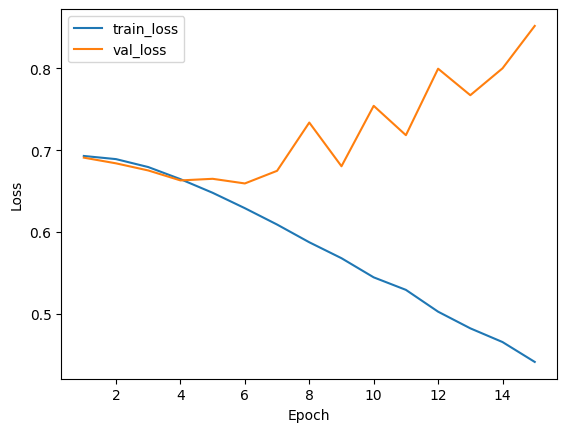

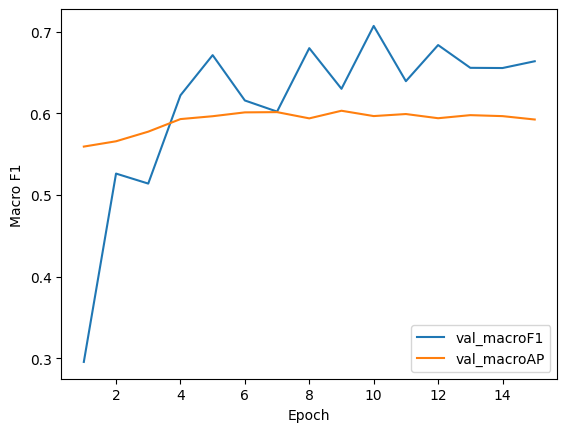

[np.float64(0.38), np.float64(0.38), np.float64(0.41000000000000003), np.float64(0.51)]
current_best_score=0.707181663986125 max_val=0.686 current best weight_decay=1e-05
weight decay=5e-05


'VAL  loss=0.837 exact=0.152 hamming_loss=0.376 microF1=0.676 macroF1=0.633 per_label_acc=[0.571 0.734 0.647 0.544] per_label_f1=[0.532 0.569 0.647 0.512]'

  0%|          | 0/15 [00:00<?, ?it/s]

loaded model from epoch 9


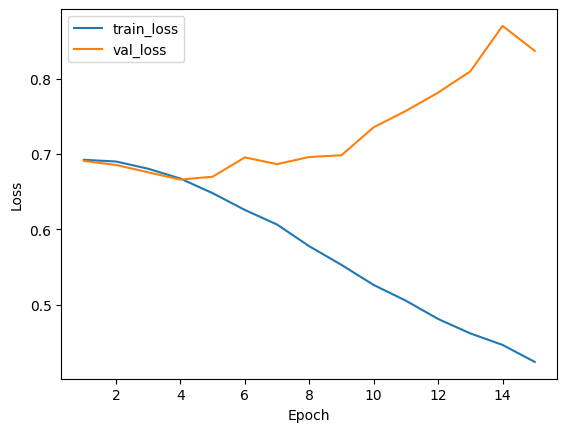

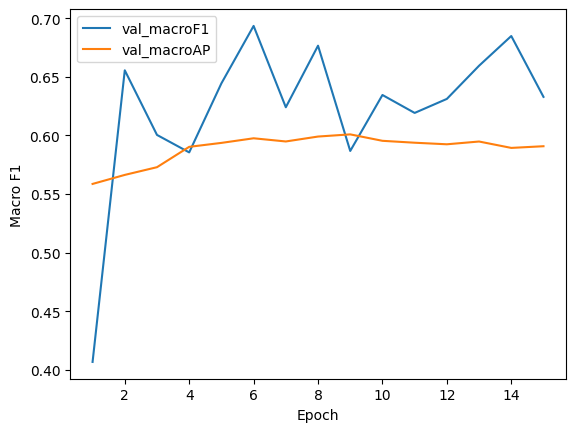

[np.float64(0.37), np.float64(0.3), np.float64(0.47000000000000003), np.float64(0.48)]
current_best_score=0.6934421939442778 max_val=0.686 current best weight_decay=1e-05
weight decay=0.0001


'VAL  loss=0.867 exact=0.164 hamming_loss=0.360 microF1=0.714 macroF1=0.691 per_label_acc=[0.633 0.749 0.666 0.512] per_label_f1=[0.566 0.58  0.665 0.512]'

  0%|          | 0/15 [00:00<?, ?it/s]

loaded model from epoch 10


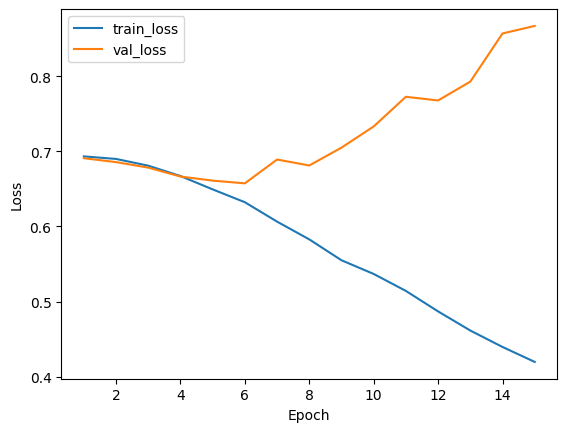

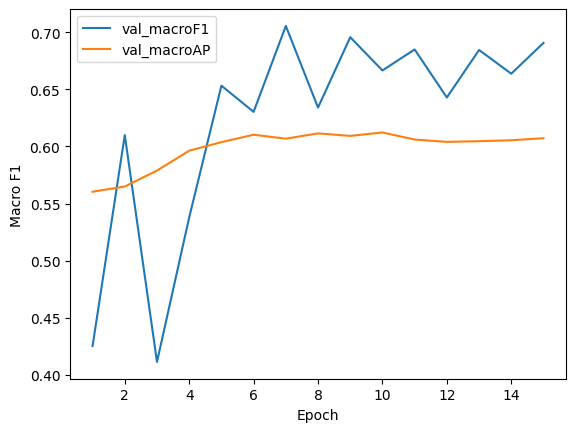

[np.float64(0.42), np.float64(0.41000000000000003), np.float64(0.42), np.float64(0.5)]
current_best_score=0.705422979135109 max_val=0.696 current best weight_decay=0.0001
weight decay=0.0005


'VAL  loss=0.871 exact=0.197 hamming_loss=0.344 microF1=0.726 macroF1=0.691 per_label_acc=[0.684 0.782 0.669 0.49 ] per_label_f1=[0.601 0.584 0.664 0.49 ]'

  0%|          | 0/15 [00:00<?, ?it/s]

loaded model from epoch 10


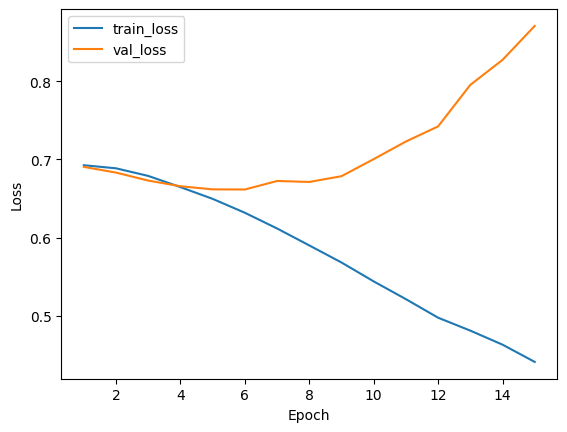

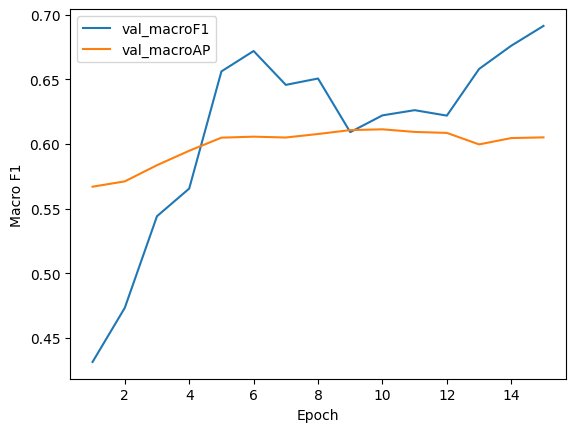

[np.float64(0.31), np.float64(0.24), np.float64(0.58), np.float64(0.53)]
current_best_score=0.6912415654594302 max_val=0.696 current best weight_decay=0.0001
weight decay=0.001


'VAL  loss=0.932 exact=0.201 hamming_loss=0.353 microF1=0.687 macroF1=0.632 per_label_acc=[0.607 0.729 0.682 0.571] per_label_f1=[0.548 0.53  0.67  0.523]'

  0%|          | 0/15 [00:00<?, ?it/s]

loaded model from epoch 8


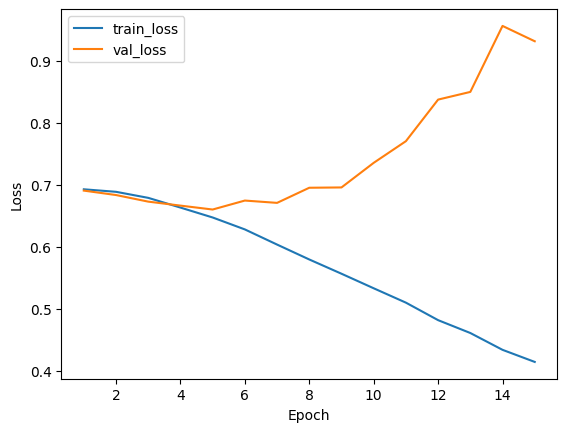

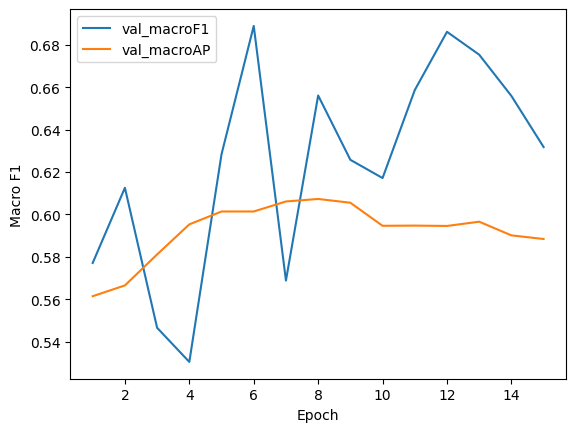

[np.float64(0.47000000000000003), np.float64(0.49), np.float64(0.41000000000000003), np.float64(0.52)]
current_best_score=0.6889517227793854 max_val=0.696 current best weight_decay=0.0001
weight decay=0.005


'VAL  loss=0.896 exact=0.202 hamming_loss=0.347 microF1=0.718 macroF1=0.679 per_label_acc=[0.682 0.752 0.662 0.514] per_label_f1=[0.591 0.551 0.657 0.511]'

  0%|          | 0/15 [00:00<?, ?it/s]

loaded model from epoch 9


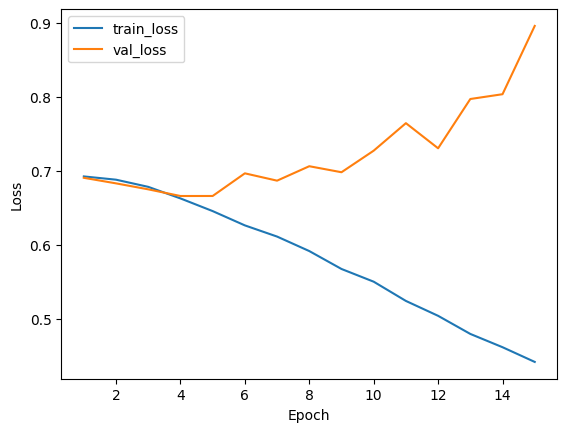

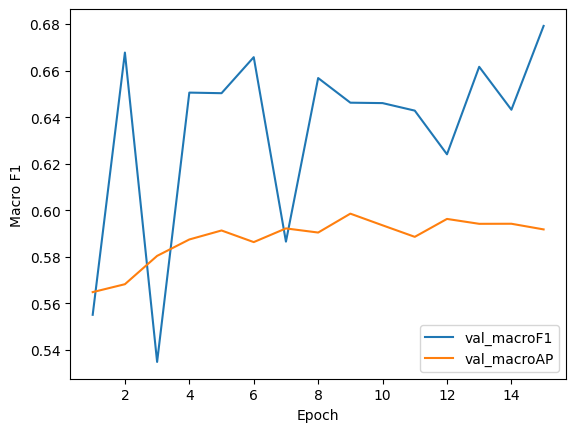

[np.float64(0.38), np.float64(0.31), np.float64(0.56), np.float64(0.56)]
current_best_score=0.6792109635970361 max_val=0.696 current best weight_decay=0.0001
weight decay=0.01


'VAL  loss=0.919 exact=0.209 hamming_loss=0.332 microF1=0.750 macroF1=0.715 per_label_acc=[0.719 0.806 0.655 0.493] per_label_f1=[0.567 0.556 0.653 0.491]'

  0%|          | 0/15 [00:00<?, ?it/s]

loaded model from epoch 6


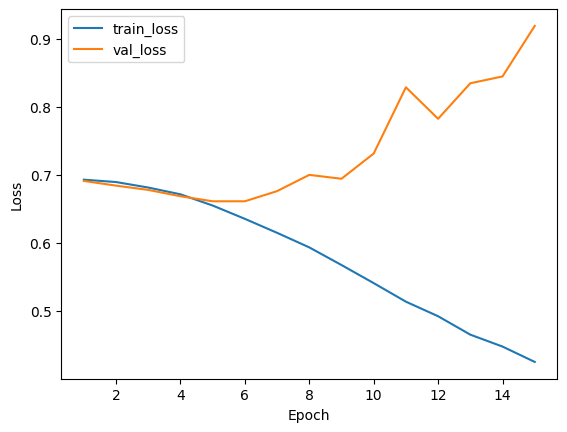

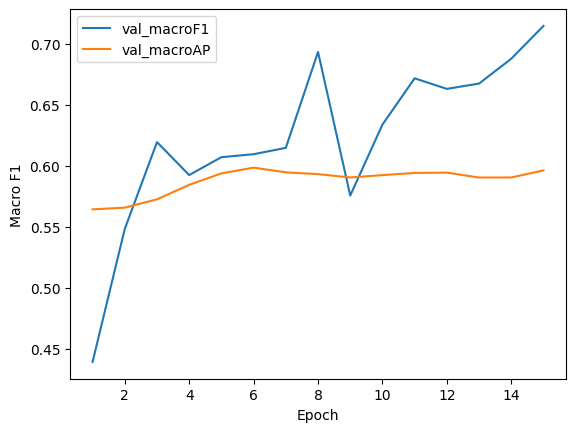

[np.float64(0.45), np.float64(0.32), np.float64(0.52), np.float64(0.49)]
current_best_score=0.7145387426355433 max_val=0.706 current best weight_decay=0.01


In [15]:
# tune weight_decay
iterate_weight_decay = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
max_val  = -np.inf
best_weight_decay = -np.inf
for weight_decay in iterate_weight_decay:
        model = LSTM_MBTI()
        print(f"weight decay={weight_decay}")
        model, best_score = train(model, weight_decay=weight_decay, output=True)
        thresholds = tune_thresholds(model, cfg_val_loader)
        val = evaluate(model, cfg_val_loader, thresholds=thresholds)
        if val["macroF1"] > max_val:
                max_val = val["macroF1"]
                best_weight_decay = weight_decay
        print(f"current_best_score={best_score}",f"max_val={max_val:.3f}",f"current best weight_decay={best_weight_decay}")

dropout=0.2


'VAL  loss=0.895 exact=0.187 hamming_loss=0.359 microF1=0.702 macroF1=0.665 per_label_acc=[0.668 0.696 0.655 0.546] per_label_f1=[0.583 0.523 0.655 0.528]'

  0%|          | 0/15 [00:00<?, ?it/s]

loaded model from epoch 7


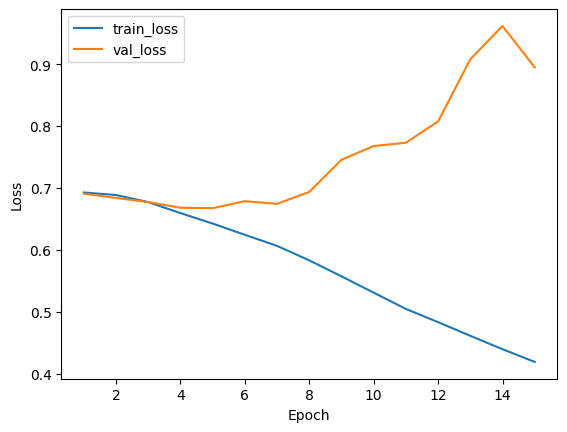

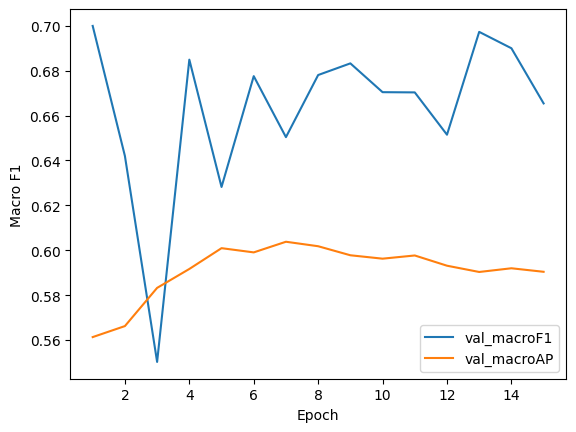

[np.float64(0.46), np.float64(0.35000000000000003), np.float64(0.44), np.float64(0.5)]
current_best_score=0.6998839203654006 max_val=0.702 current best dropout=0.2
dropout=0.3


'VAL  loss=0.876 exact=0.187 hamming_loss=0.353 microF1=0.720 macroF1=0.689 per_label_acc=[0.666 0.757 0.672 0.495] per_label_f1=[0.579 0.536 0.671 0.494]'

  0%|          | 0/15 [00:00<?, ?it/s]

loaded model from epoch 13


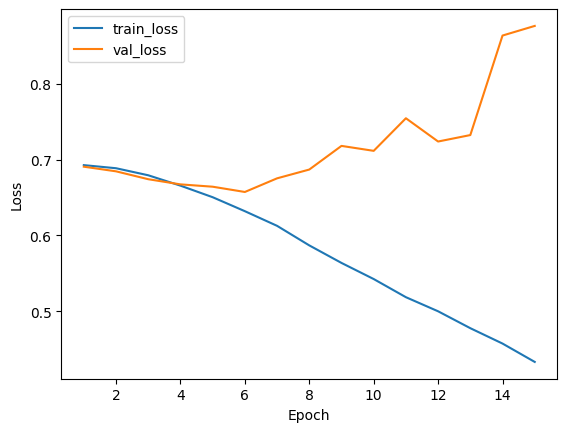

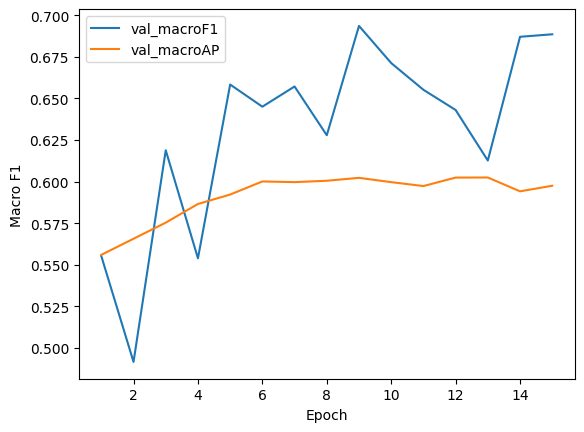

[np.float64(0.24), np.float64(0.34), np.float64(0.38), np.float64(0.48)]
current_best_score=0.6935669889298828 max_val=0.702 current best dropout=0.2
dropout=0.4


'VAL  loss=0.841 exact=0.163 hamming_loss=0.373 microF1=0.687 macroF1=0.656 per_label_acc=[0.585 0.721 0.664 0.54 ] per_label_f1=[0.539 0.545 0.664 0.529]'

  0%|          | 0/15 [00:00<?, ?it/s]

loaded model from epoch 10


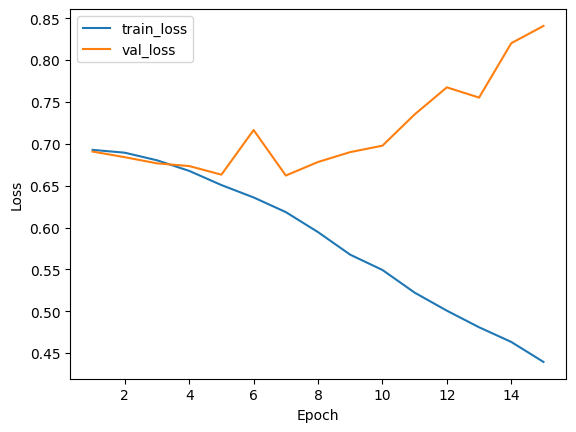

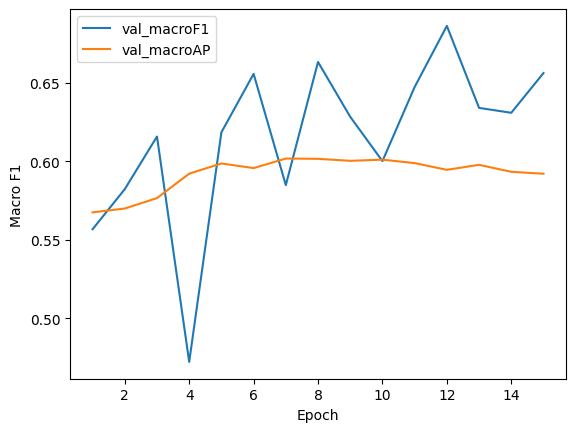

[np.float64(0.36), np.float64(0.3), np.float64(0.45), np.float64(0.49)]
current_best_score=0.6862507170513132 max_val=0.702 current best dropout=0.2
dropout=0.5


'VAL  loss=0.877 exact=0.179 hamming_loss=0.352 microF1=0.702 macroF1=0.662 per_label_acc=[0.63  0.737 0.684 0.54 ] per_label_f1=[0.547 0.563 0.677 0.525]'

  0%|          | 0/15 [00:00<?, ?it/s]

loaded model from epoch 8


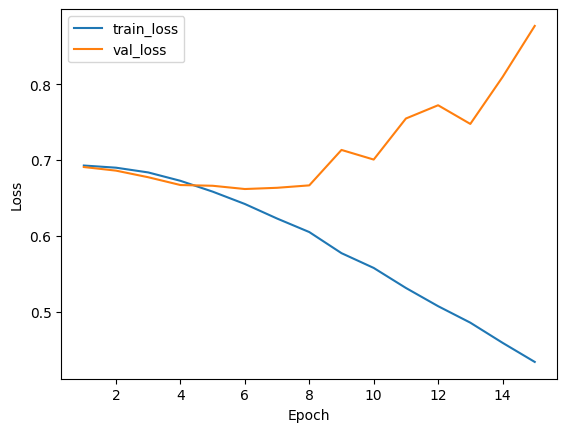

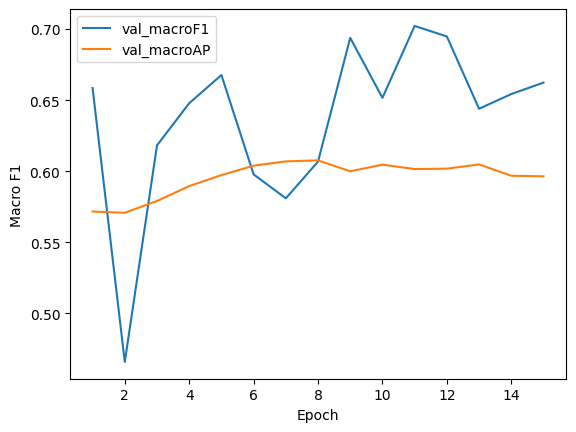

[np.float64(0.37), np.float64(0.3), np.float64(0.47000000000000003), np.float64(0.5)]
current_best_score=0.7022234714500162 max_val=0.703 current best dropout=0.5


In [16]:
# tune dropout
iterate_dropout = [0.2, 0.3, 0.4, 0.5]
max_val  = -np.inf
best_dropout = -np.inf
for dropout in iterate_dropout:
        model = LSTM_MBTI(dropout=dropout)
        print(f"dropout={dropout}")
        model, best_score = train(model)
        thresholds = tune_thresholds(model, cfg_val_loader)
        val = evaluate(model, cfg_val_loader, thresholds=thresholds)
        if val["macroF1"] > max_val:
                max_val = val["macroF1"]
                best_dropout = dropout
        print(f"current_best_score={best_score}",f"max_val={max_val:.3f}",f"current best dropout={best_dropout}")

max_grad_norm=0.5


'VAL  loss=0.899 exact=0.166 hamming_loss=0.347 microF1=0.721 macroF1=0.685 per_label_acc=[0.654 0.761 0.67  0.526] per_label_f1=[0.566 0.533 0.667 0.523]'

  0%|          | 0/15 [00:00<?, ?it/s]

loaded model from epoch 10


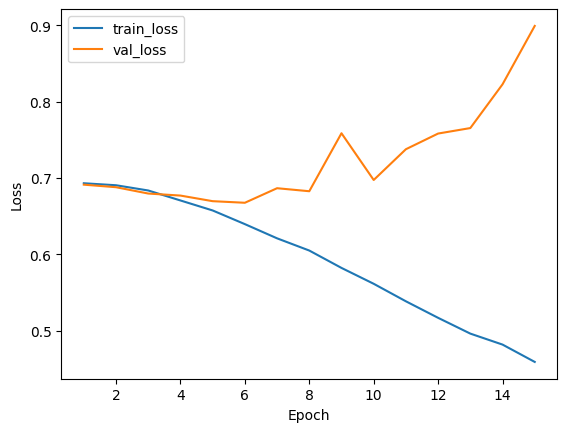

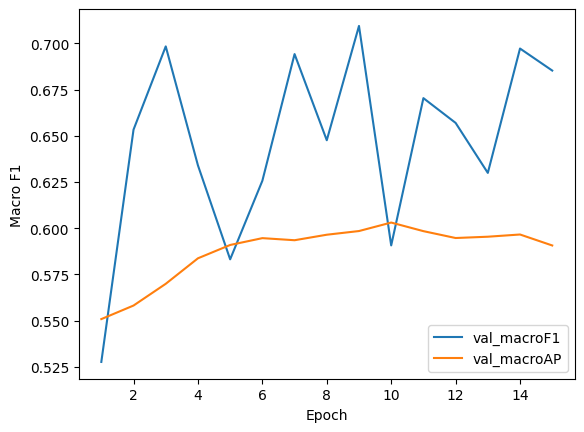

[np.float64(0.25), np.float64(0.29), np.float64(0.47000000000000003), np.float64(0.48)]
current_best_score=0.7094713674068717 max_val=0.696 current best max_grad_norm=0.5
max_grad_norm=1.0


'VAL  loss=0.972 exact=0.171 hamming_loss=0.359 microF1=0.708 macroF1=0.664 per_label_acc=[0.69  0.742 0.633 0.498] per_label_f1=[0.578 0.549 0.623 0.495]'

  0%|          | 0/15 [00:00<?, ?it/s]

loaded model from epoch 8


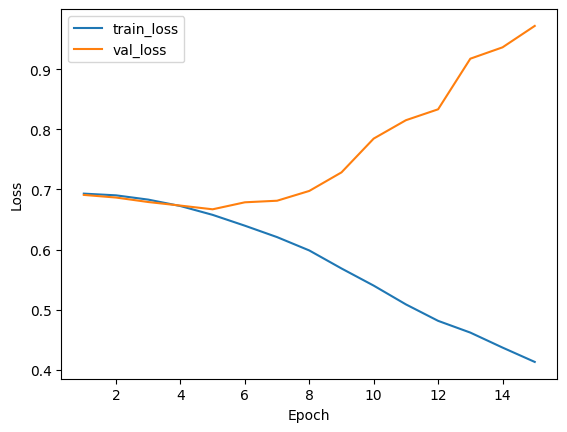

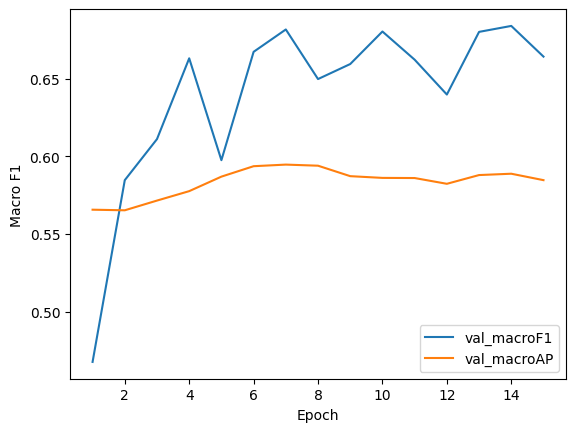

[np.float64(0.4), np.float64(0.24), np.float64(0.58), np.float64(0.52)]
current_best_score=0.6838494852393687 max_val=0.696 current best max_grad_norm=0.5
max_grad_norm=1.5


'VAL  loss=0.904 exact=0.157 hamming_loss=0.368 microF1=0.691 macroF1=0.656 per_label_acc=[0.624 0.707 0.659 0.537] per_label_f1=[0.559 0.539 0.658 0.523]'

  0%|          | 0/15 [00:00<?, ?it/s]

loaded model from epoch 6


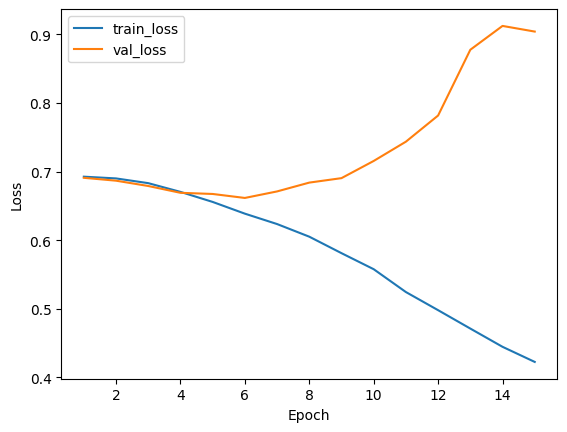

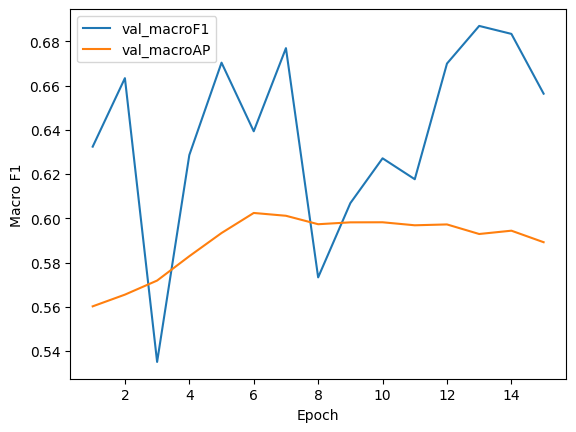

[np.float64(0.47000000000000003), np.float64(0.39), np.float64(0.44), np.float64(0.5)]
current_best_score=0.6869525370535442 max_val=0.696 current best max_grad_norm=0.5
max_grad_norm=2.0


'VAL  loss=0.944 exact=0.170 hamming_loss=0.381 microF1=0.670 macroF1=0.628 per_label_acc=[0.565 0.689 0.663 0.561] per_label_f1=[0.515 0.529 0.663 0.516]'

  0%|          | 0/15 [00:00<?, ?it/s]

loaded model from epoch 11


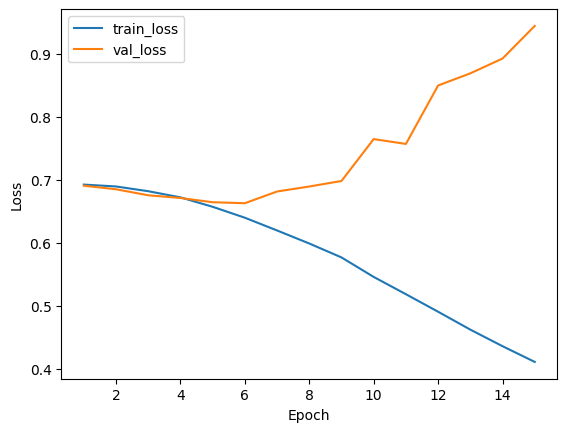

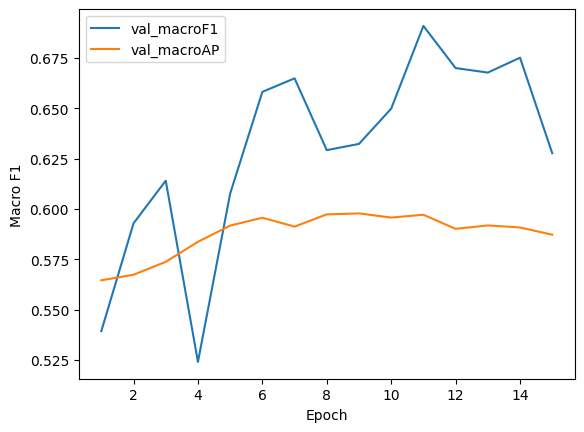

[np.float64(0.54), np.float64(0.31), np.float64(0.53), np.float64(0.54)]
current_best_score=0.6909485743581142 max_val=0.696 current best max_grad_norm=0.5


In [138]:
# tune max_grad_norm
iterate_max_grad_norm = [0.5, 1.0, 1.5, 2.0]
max_val  = -np.inf
best_max_grad_norm = -np.inf
for max_grad_norm in iterate_max_grad_norm:
        model = LSTM_MBTI()
        print(f"max_grad_norm={max_grad_norm}")
        model, best_score = train(model, max_grad_norm=max_grad_norm)
        thresholds = tune_thresholds(model, cfg_val_loader)
        val = evaluate(model, cfg_val_loader, thresholds=thresholds)
        if val["macroF1"] > max_val:
                max_val = val["macroF1"]
                best_max_grad_norm = max_grad_norm
        print(f"current_best_score={best_score}",f"max_val={max_val:.3f}",f"current best max_grad_norm={best_max_grad_norm}")

In [ ]:
# tune hidden_dim
iterate_hidden_dim = [128, 256, 384, 512]
max_val  = -np.inf
best_hidden_dim = -np.inf
for hidden_dim in iterate_hidden_dim:
        model = LSTM_MBTI(hidden_dim=hidden_dim)
        print(f"hidden_dim={hidden_dim}")
        model, best_score = train(model)
        thresholds = tune_thresholds(model, cfg_val_loader)
        val = evaluate(model, cfg_val_loader, thresholds=thresholds)
        if val["macroF1"] > max_val:
                max_val = val["macroF1"]
                best_hidden_dim = hidden_dim
        print(f"current_best_score={best_score}",f"max_val={max_val:.3f}",f"current best hidden_dim={best_hidden_dim}")

hidden_dim=128


'VAL  loss=0.680 exact=0.052 hamming_loss=0.468 microF1=0.515 macroF1=0.464 per_label_acc=[0.64  0.29  0.621 0.579] per_label_f1=[0.555 0.289 0.608 0.481]'

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# tune num_layers
iterate_num_layers = [1, 2, 3]
max_val  = -np.inf
best_num_layers = -np.inf
for num_layers in iterate_num_layers:
        model = LSTM_MBTI(num_layers=num_layers)
        print(f"num layers={num_layers}")
        model, best_score = train(model)
        thresholds = tune_thresholds(model, cfg_val_loader)
        val = evaluate(model, cfg_val_loader, thresholds=thresholds)
        if val["macroF1"] > max_val:
                max_val = val["macroF1"]
                best_num_layers = num_layers
        print(f"current_best_score={best_score}",f"max_val={max_val:.3f}",f"current best num_layers={best_num_layers}")

num layers=1


'VAL  loss=1.319 exact=0.130 hamming_loss=0.401 microF1=0.646 macroF1=0.607 per_label_acc=[0.596 0.605 0.631 0.564] per_label_f1=[0.545 0.512 0.627 0.507]'

  0%|          | 0/100 [00:00<?, ?it/s]

Early stopping. Best Macro AP=0.6025
[np.float64(0.29), np.float64(0.34), np.float64(0.6900000000000001), np.float64(0.53)]
current_best_score=0.6669529424203215 max_val=0.670 current best num_layers=1
num layers=2


'VAL  loss=2.318 exact=0.136 hamming_loss=0.401 microF1=0.681 macroF1=0.670 per_label_acc=[0.609 0.661 0.618 0.508] per_label_f1=[0.581 0.523 0.609 0.506]'

  0%|          | 0/100 [00:00<?, ?it/s]

Early stopping. Best Macro AP=0.5997
[np.float64(0.42), np.float64(0.46), np.float64(0.42), np.float64(0.59)]
current_best_score=0.6698743686388966 max_val=0.670 current best num_layers=1
num layers=3


'VAL  loss=2.737 exact=0.134 hamming_loss=0.389 microF1=0.658 macroF1=0.593 per_label_acc=[0.588 0.655 0.639 0.562] per_label_f1=[0.54  0.516 0.634 0.462]'

  0%|          | 0/100 [00:00<?, ?it/s]

Early stopping. Best Macro AP=0.5926
[np.float64(0.34), np.float64(0.47000000000000003), np.float64(0.49), np.float64(0.51)]
current_best_score=0.6765625157791841 max_val=0.670 current best num_layers=1


In [ ]:
# test if bidirectional
iterate_directions = [True, False]
max_val  = -np.inf
best_directions = True
for directions in iterate_directions:
        model = LSTM_MBTI(bidirectional=directions)
        print(f"bidirectional={directions}")
        model, best_score = train(model)
        thresholds = tune_thresholds(model, cfg_val_loader)
        val = evaluate(model, cfg_val_loader, thresholds=thresholds)
        if val["macroF1"] > max_val:
                max_val = val["macroF1"]
                best_directions = directions
        print(f"current_best_score={best_score}",f"max_val={max_val:.3f}",f"Bidirectional={best_directions}")

bidirectional=True


'VAL  loss=3.553 exact=0.162 hamming_loss=0.370 microF1=0.687 macroF1=0.655 per_label_acc=[0.624 0.683 0.646 0.568] per_label_f1=[0.58  0.544 0.644 0.542]'

  0%|          | 0/100 [00:00<?, ?it/s]

Early stopping. Best Macro AP=0.6049
[np.float64(0.54), np.float64(0.9400000000000001), np.float64(0.74), np.float64(0.9)]
current_best_score=0.6857193717795812 max_val=0.636 Bidirectional=True
bidirectional=False


'VAL  loss=2.119 exact=0.128 hamming_loss=0.391 microF1=0.671 macroF1=0.633 per_label_acc=[0.588 0.717 0.605 0.525] per_label_f1=[0.553 0.522 0.605 0.506]'

  0%|          | 0/100 [00:00<?, ?it/s]

Early stopping. Best Macro AP=0.5953
[np.float64(0.53), np.float64(0.39), np.float64(0.46), np.float64(0.55)]
current_best_score=0.6749039553898967 max_val=0.665 Bidirectional=False


In [ ]:
# tune embed_dim
iterate_embed_dim = [128, 256, 384, 512]
max_val  = -np.inf
best_embed_dim = -np.inf
for embed_dim in iterate_embed_dim:
        model = LSTM_MBTI(embed_dim=embed_dim)
        print(f"embed dim={embed_dim}")
        model, best_score = train(model)
        thresholds = tune_thresholds(model, cfg_val_loader)
        val = evaluate(model, cfg_val_loader, thresholds=thresholds)
        if val["macroF1"] > max_val:
                max_val = val["macroF1"]
                best_embed_dim = embed_dim
        print(f"current_best_score={best_score}",f"max_val={max_val:.3f}",f"current best embed_dim={best_embed_dim}")

embed dim=128


'VAL  loss=1.628 exact=0.155 hamming_loss=0.368 microF1=0.700 macroF1=0.676 per_label_acc=[0.615 0.728 0.655 0.531] per_label_f1=[0.58  0.517 0.655 0.53 ]'

  0%|          | 0/100 [00:00<?, ?it/s]

Early stopping. Best Macro AP=0.6120
[np.float64(0.44), np.float64(0.47000000000000003), np.float64(0.5), np.float64(0.52)]
current_best_score=0.6894923192049486 max_val=0.666 current best embed_dim=128
embed dim=256


'VAL  loss=2.456 exact=0.155 hamming_loss=0.392 microF1=0.655 macroF1=0.615 per_label_acc=[0.572 0.646 0.618 0.598] per_label_f1=[0.539 0.518 0.613 0.54 ]'

  0%|          | 0/100 [00:00<?, ?it/s]

Early stopping. Best Macro AP=0.6019
[np.float64(0.3), np.float64(0.51), np.float64(0.66), np.float64(0.42)]
current_best_score=0.6801006363138278 max_val=0.666 current best embed_dim=128
embed dim=384


'VAL  loss=3.207 exact=0.151 hamming_loss=0.371 microF1=0.690 macroF1=0.650 per_label_acc=[0.633 0.691 0.631 0.561] per_label_f1=[0.568 0.532 0.629 0.527]'

  0%|          | 0/100 [00:00<?, ?it/s]

Early stopping. Best Macro AP=0.6126
[np.float64(0.28), np.float64(0.53), np.float64(0.61), np.float64(0.48)]
current_best_score=0.6713474228752384 max_val=0.669 current best embed_dim=384
embed dim=512


'VAL  loss=2.517 exact=0.188 hamming_loss=0.355 microF1=0.695 macroF1=0.657 per_label_acc=[0.633 0.7   0.641 0.605] per_label_f1=[0.599 0.544 0.638 0.566]'

  0%|          | 0/100 [00:00<?, ?it/s]

Early stopping. Best Macro AP=0.6249
[np.float64(0.85), np.float64(0.22), np.float64(0.89), np.float64(0.55)]
current_best_score=0.6786961093241481 max_val=0.669 current best embed_dim=384


Testing

'VAL  loss=0.701 exact=0.160 hamming_loss=0.387 microF1=0.672 macroF1=0.646 per_label_acc=[0.609 0.672 0.657 0.512] per_label_f1=[0.546 0.532 0.654 0.508]'

  0%|          | 0/30 [00:00<?, ?it/s]

loaded model from epoch 9


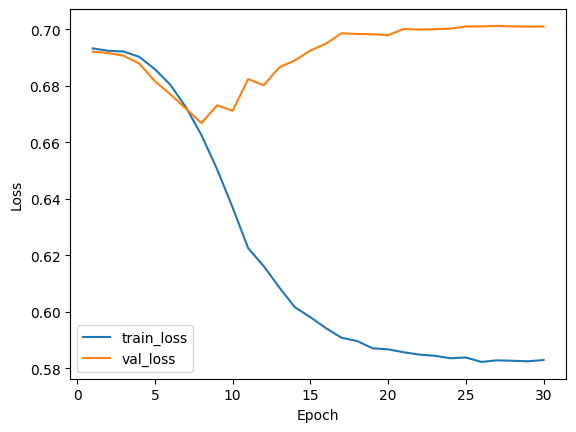

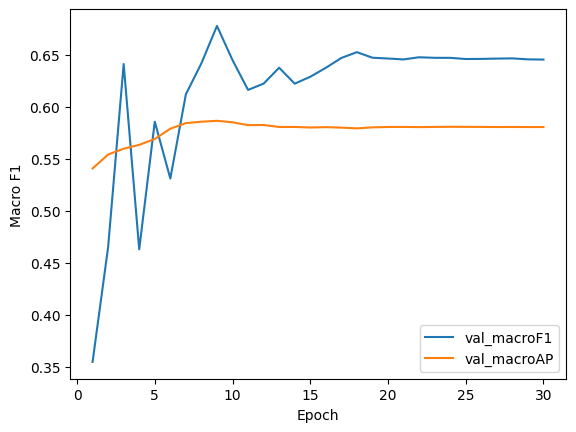

In [255]:
model = LSTM_MBTI()
model, best_score = train(model, output=True)


In [256]:
thresholds = tune_thresholds(model, cfg_val_loader)

[np.float64(0.47000000000000003), np.float64(0.46), np.float64(0.66), np.float64(0.56)]


In [257]:

val = evaluate(model, cfg_val_loader, thresholds=thresholds)
print(f"VAL loss={val["loss"]:.3f} exact={val["exact"]:.3f} hamming_loss={val["hamming_loss"]:.3f} "
            f"microF1={val["microF1"]:.3f}\033[31m macroF1={val["macroF1"]:.3f}\033[0m per_label_acc={np.round(val["per_label_acc"], 3)} "
            f"per_label_f1={np.round(val["per_label_f1"], 3)}")

test = evaluate(model, cfg_test_loader, thresholds=thresholds)
print(f"TEST loss={test["loss"]:.3f} exact={test["exact"]:.3f} hamming_loss={test["hamming_loss"]:.3f} "
            f"microF1={test["microF1"]:.3f}\033[31m macroF1={test["macroF1"]:.3f}\033[0m per_label_acc={np.round(test["per_label_acc"], 3)} "
            f"per_label_f1={np.round(test["per_label_f1"], 3)}")

VAL loss=0.673 exact=0.205 hamming_loss=0.325 microF1=0.736 macroF1=0.683 per_label_acc=[0.679 0.795 0.679 0.547] per_label_f1=[0.565 0.547 0.675 0.526]
TEST loss=0.692 exact=0.180 hamming_loss=0.351 microF1=0.712 macroF1=0.660 per_label_acc=[0.652 0.763 0.642 0.54 ] per_label_f1=[0.562 0.484 0.638 0.517]


In [258]:

save_path = str(Path(path).parent / "model.pt")
torch.save({
    "model_state_dict": model.state_dict(),
    "tok": tok,
    "thresholds": thresholds,
}, save_path)


In [259]:

ckpt = torch.load(str(Path(path).parent / "model.pt"), map_location="cuda", weights_only=False)

model = LSTM_MBTI()
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

thresholds = ckpt.get("thresholds")
tok = ckpt.get("tok")


In [260]:
def tokenize_text(text, tokenizer):
    text = regex.sub(r"http[^\s|]+", " __url__ ", text)
    text = text.replace("|||", " __sep__ ")
    text = regex.sub(r"(?i)\b[IE][NS][TF][JP]\b", " __tar__ ", text)
    text = regex.sub(r"\s+", " ", text)
    rx = regex.compile(r"[^_\p{White_Space}\p{scx=Latin}\p{Emoji}]+")
    text = rx.sub("", text)
    
    return tokenizer.encode(text)

In [261]:
one_out = ["I", "N", "T", "J"]
zero_out = ["E", "S", "F", "P"]
def predict(model, tokenized_text, thresholds):
    model = model.to(device)
    model.eval()
    data = torch.tensor(tokenized_text.ids, dtype=torch.long).unsqueeze(0)
    data = data.to(device)
    with torch.no_grad():
        out = model(data)
    logits = out
    probs = torch.sigmoid(logits)
    thr = torch.tensor(thresholds, dtype=probs.dtype, device=probs.device).view(1, 4)
    bits = (probs >= thr).int()
    mbti = "".join(one_out[i] if bits[0, i].item() == 1 else zero_out[i] for i in range(4))
    
    return mbti

In [262]:
text = "whatever sorry i got so angry , in the end its just a game ||| it was easy winable if the team plays arroudn me, you just press r on whoever goes on me and we can win ||| so it didnt matter if you are berhind in the game or anything ||| with draven being behind the game can be centerd arround the 3-1 viktor 500 first strike gold plates ||| i know when i can carry a game and you should atleast ask if i want to ff ||| but liek i said in the end its just game so ||| these things happen ||| I'm still here ||| It's exhausting ||| Because we are 3 people, 3 is never good number to travel ||| well tbh ||| lyon is nice, i like the views everything ||| but it was a bad trip ||| just a lot of arguing being angry and stuff ||| im goign to visit  lyon tomrorow for a week ||| hope the french dont kill me ||| Wtf ||| What a life ||| Maybe I should hire someone to do it for me as well ||| What if they find something secret from you while the, clean"
tokens = tokenize_text(text, tok)
out = predict(model, tokens, thresholds)
print(out)

ISTP
